In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
df = pd.read_csv("Data.csv")
features = ["Value", "Age"]

df = df.dropna(subset=features)
data = df[features].copy()
data = ((data - data.min()) / (data.max() - data.min())) * 10 + 1

In [3]:
from sklearn.cluster import KMeans

def gap_statistic(X):
    # Fit KMeans clustering for different values of k
    ks = range(1, 10)
    kmeans = [KMeans(n_clusters=k).fit(X) for k in ks]

    # Get intra-cluster distances for each k
    intra_distances = [k.inertia_ for k in kmeans]

    # Generate reference datasets for each k
    ref_intra_distances = []
    for k in ks:
        # Generate random reference dataset with same shape as X
        X_ref = np.random.rand(*X.shape)

        # Fit KMeans clustering on reference dataset
        kmeans_ref = KMeans(n_clusters=k).fit(X_ref)

        # Get intra-cluster distances for reference dataset
        ref_intra_distances.append(kmeans_ref.inertia_)

    # Calculate gap statistic
    gap = np.log(ref_intra_distances) - np.log(intra_distances)
    optimal_k = np.argmax(gap) + 1

    

    return optimal_k

In [4]:
def random_labels(data, k):
    return np.random.randint(0, k, size=len(data))

def random_centroids(data, k):
    centroids = []
    for i in range(k):
        centroid = data.apply(lambda x: float(x.sample()))
        centroids.append(centroid)
    return pd.concat(centroids, axis=1)

def get_labels(data, centroids):
    distances = centroids.apply(lambda x: np.sqrt(((data - x) ** 2).sum(axis=1)))
    return distances.idxmin(axis=1)

def new_centroids(data, labels, k):
    centroids = data.groupby(labels).apply(lambda x: np.exp(np.log(x).mean())).T
    return centroids

def plot_clusters(data, labels, centroids, iteration):
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    centroids_2d = pca.transform(centroids.T)
    clear_output(wait=True)
    plt.title(f'Iteration {iteration}')
    plt.scatter(x=data_2d[:,0], y=data_2d[:,1], c=labels)
    plt.scatter(x=centroids_2d[:,0], y=centroids_2d[:,1])
    plt.show()


In [5]:
def kmeans(data, k):
    max_iterations = 100

    # Assign labels randomly to clusters
    labels = random_labels(data, k)
    
    centroids = random_centroids(data, k)
    old_centroids = pd.DataFrame()
    iteration = 1

    while iteration < max_iterations and not centroids.equals(old_centroids):
        old_centroids = centroids
        
        labels = get_labels(data, centroids)
        centroids = new_centroids(data, labels, k)
        plot_clusters(data, labels, centroids, iteration)
        iteration += 1

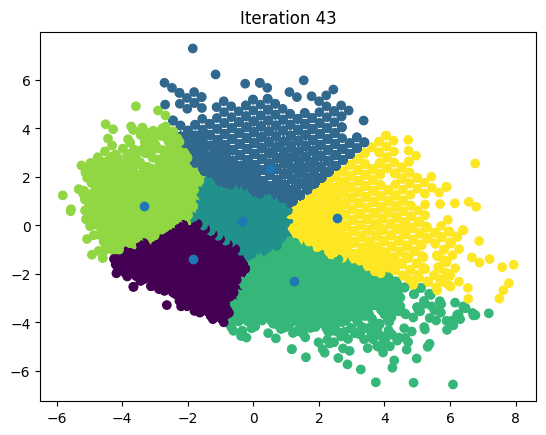

In [6]:
optimal_k = gap_statistic(data)
kmeans(data, optimal_k)